# Figure 2: Ensemble epistasis depends on excited structure stability

## Imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

## Functions

In [2]:
def en(dG_j,dG_k,T,R=0.008314):
    """
    Boltzmann-weighted free energy of conformations j and k.
    
    dG_j: stability of conformation j
    dG_k: stability of conformation k
    T: temperature (K)
    R: gas constant"""
    
    RT = R*T
    
    return -RT*np.log(np.exp(-dG_j/RT) + np.exp(-dG_k/RT))


def get_epistasis(dG_i,dG_j,dG_k,             
                  ddG_i_A,ddG_j_A,ddG_k_A,
                  ddG_i_B,ddG_j_B,ddG_k_B,
                  T=298,R=0.008314):
    """
    Return the epistasis in dG_obs between two mutations introduced into a
    three-conformation system. 
    
    dG_i, dG_j, dG_k: dG of conformations i, j, and k for genotype ab
    ddG_i_A, ddG_j_A, ddG_k_A: effect of mutation A on conformations i, j, and k
    ddG_i_B, ddG_j_B, ddG_k_B: effect of mutation B on conformations i, j, and k
    T: temperature
    R: gas constant
    
    returns:
        magnitude of epistasis (sign is (AB - aB) - (Ab - ab))
        whether sign in A (True,False)
        whether sign in B (Ture,False)
        type of epistasis as a string (none, magnitude, sign, reciprocal_sign)
    """
    
    # observables
    ab = dG_i                     - en(dG_j,                    dG_k,                    T,R)
    Ab = dG_i + ddG_i_A           - en(dG_j + ddG_j_A,          dG_k + ddG_k_A,          T,R)
    aB = dG_i +           ddG_i_B - en(dG_j +           ddG_j_B,dG_k +           ddG_k_B,T,R)
    AB = dG_i + ddG_i_A + ddG_i_B - en(dG_j + ddG_j_A + ddG_j_B,dG_k + ddG_k_A + ddG_k_B,T,R)
    
    # magnitude
    mag_in_a = (AB - aB) - (Ab - ab)
    mag_in_b = (AB - Ab) - (aB - ab)
    if mag_in_a == 0:
        return mag_in_a, mag_in_b, False, False, "none"

    ep_type = "magnitude"
    
    # sign in A
    s1 = (AB - aB)/np.abs(AB - aB)
    s2 = (Ab - ab)/np.abs(Ab - ab)
    sign_in_a = False
    if s1 != s2:
        ep_type = "sign"
        sign_in_a = True
    
    # sign in B
    s1 = (AB - Ab)/np.abs(AB - Ab)
    s2 = (aB - ab)/np.abs(aB - ab)
    sign_in_b = False
    if s1 != s2:
        ep_type = "sign"
        sign_in_b = True
    
    # reciprocal
    if sign_in_a and sign_in_b:
        ep_type = "reciprocal_sign"
        
        
    
    
    return mag_in_a, mag_in_b, sign_in_a, sign_in_b, ep_type
    

In [3]:
def plot_surface(some_array,x_array,y_array,flip_color=True,max_value=None,cmap="bwr",
                 xlabel=None,ylabel=None):
    """
    Plot a contour map.
    
    some_array: n x m 2D array
    x_array: array with (at least) [min_x,max_x]
    y_array: array with (at least) [min_y,max_y]
    flip_color: whether or not to flip values in some_array before plotting
    max_value: set min and max color to -max_value and +max_value
        None: get max_value from the array by max(abs(some_array))
        float: use abs(max_value) given
    cmap: matplotlib color map to use
    xlabel: x label
    ylabel: y label
    """

    # Flip color
    if flip_color:
        plot_array = -some_array

    else:
        plot_array = some_array
    
    # Set max color
    if max_value is None:
        extreme = np.max(np.abs(plot_array))

    else:
        extreme = np.abs(max_value)
        
    # Plot it
    plt.imshow(plot_array,
               cmap=cmap,origin="left",vmin=-extreme,vmax=extreme,
               extent=[x_array[0],x_array[-1],y_array[0],y_array[-1],],
               interpolation="none")
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    
    if ylabel is not None:
        plt.ylabel(ylabel)
        
        
def _plot_states(dG_j,dG_k,
                 ddG_j=None,ddG_k=None,
                 observable=0,
                 x_location=0,arrow_colors=None):
    """
    Draw conformation energies and effects of mutations for a given genotype.
    
    dG_j: stability of conformation j before mutation
    dG_k: stability of conformation k before mutation
    ddG_j: effect of mutations to conformation j.  
           If None, no mutations.
           If float, single mutation (one arrow).
           If list of floats, multiple mutations (each with own arrow)
    ddG_k: effect of mutations to conformation k.  (Same syntax as ddG_j).
    observable: observable <dGjk>
    x_location: where to draw states on total plot.
    arrow_colors: color to draw each arrow.
                  If None, all arrows black.
                  Otherwise, must be a list of colors, in order.  Arrows are
                  plotted in order ddG_j, then ddG_k.   
    """

    # x-placement for edges of genotypes
    x0 = 0
    x1 = 2
    x2 = 2.5
    x3 = 4.5

    # If ddG_j specified, add dashed line for dG_j
    if ddG_j is None:
        ddG_j = 0
    else:        
        plt.plot([x0+x_location,x1+x_location],[dG_j,dG_j],"--",lw=2,color="purple",zorder=10)

    # If ddG_k specified, add dashed line for dG_k
    if ddG_k is None:
        ddG_k = 0
    else:        
        plt.plot([x2+x_location,x3+x_location],[dG_k,dG_k],"--",lw=2,color="blue",zorder=10)
    
    # If ddG_j is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    try:
        len(ddG_j)
        total_ddG_j = sum(ddG_j)
    except TypeError:
        total_ddG_j = ddG_j
        ddG_j = [ddG_j,]

    # If ddG_k is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    try:
        len(ddG_k)
        total_ddG_k = sum(ddG_k)
    except TypeError:
        total_ddG_k = ddG_k
        ddG_k = [ddG_k,]
    
    # Plot energy levels
    plt.plot([x0+x_location,x1+x_location],[dG_j+total_ddG_j,dG_j+total_ddG_j],lw=2,color="purple",zorder=10)
    plt.plot([x2+x_location,x3+x_location],[dG_k+total_ddG_k,dG_k+total_ddG_k],lw=2,color="blue",zorder=10)
    
    # Plot observable
    plt.plot([x0+x_location,x3+x_location],[observable,observable],lw=4,color="black",zorder=0)
    
    # Count through arrow colors
    color_counter = 0
    
    current = dG_j
    for counter, j_arrow in enumerate(ddG_j):
        
        # If this ddG is 0, do not draw an arrow
        if j_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x0 + (x1 - x0)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = j_arrow/np.abs(j_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        
        # Draw arrow
        plt.arrow(x,current,0,j_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        # Update counters
        current = current + j_arrow
        color_counter += 1
        
    current = dG_k
    for counter, k_arrow in enumerate(ddG_k):
        
        # If this ddG is 0, do not draw an arrow
        if k_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x2 + (x3 - x2)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = k_arrow/np.abs(k_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        
        # Draw arrow
        plt.arrow(x,current,0,k_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        # Update counters
        current = current + k_arrow
        color_counter += 1
    

def plot_state_cycle(dG_j=0,dG_k=0,
                     ddG_Aj=-4,ddG_Ak=4,
                     ddG_Bj=-4,ddG_Bk=4,
                     T=298,R=0.008314,
                     ylim=(-14,14)):
    """
    dG_j: stability of conformation j, ab genotype
    dG_k: stability of conformation k, ab genotype
    ddG_Aj: effect of mutation A on conformation j
    ddG_Ak: effect of mutation A on conformation k
    ddG_Bj: effect of mutation B on conformation j
    ddG_Bk: effect of mutation B on conformation k
    T: temperature (K)
    R: gas constant
    y_lim: y-limits of plot
    """
    
    # Calculate observables for ab, Ab, aB, and AB genotypes
    RT = R*T
    
    ab = en(dG_j                  , dG_k,                  T,R)
    Ab = en(dG_j + ddG_Aj         , dG_k + ddG_Ak,         T,R)
    aB = en(dG_j          + ddG_Bj, dG_k          + ddG_Bk,T,R)
    AB = en(dG_j + ddG_Aj + ddG_Bj, dG_k + ddG_Ak + ddG_Bk,T,R)
    
    #print(dG_j-dG_k,ddG_Aj-ddG_Ak,(AB-aB)-(Ab-ab))
    
    # Plot states for each genotype, offseting by x_location for each one
    _plot_states(dG_j,dG_k,observable=ab,x_location=0)
    _plot_states(dG_j,dG_k,[ddG_Aj],[ddG_Ak],observable=Ab,x_location=6,arrow_colors=["orange","orange"])
    _plot_states(dG_j,dG_k,[ddG_Bj],[ddG_Bk],observable=aB,x_location=12,arrow_colors=["green","green"])
    _plot_states(dG_j,dG_k,[ddG_Bj,ddG_Aj],[ddG_Bk,ddG_Ak],observable=AB,x_location=18,arrow_colors=["green","orange","green","orange"])
    
    # Print epistasis
    print("Ab-ab:",Ab-ab)
    print("AB-ab:",AB-aB)
    print("Epistasis:",(AB-aB)-(Ab-ab))
    
    plt.ylim(*ylim)

# Panel 2A: Epistasis parameter space (differential excited structure stability)

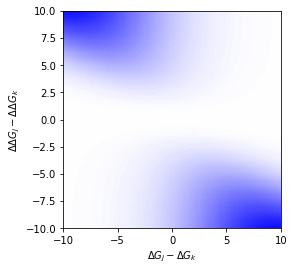

In [4]:
R = 0.008314
T = 298.0

dG_i = 0
ddG_i_A = 0
ddG_i_B = 0

dG_j = 0
ddG_j_A = 0
ddG_j_B = 0

dG_k = 0
ddG_k_A = 0
ddG_k_B = 0

d_step_size = 0.1
d_min_value = -10
d_max_value = 10
d_values = np.arange(d_min_value,
                     d_max_value+d_step_size,
                     d_step_size)

split_step_size = 0.1
split_min_value = -10
split_max_value = 10
split_values = np.arange(split_min_value,
                         split_max_value+split_step_size,
                         split_step_size)

output = np.zeros((len(split_values),len(d_values)),dtype=np.float)
for x in range(len(d_values)):
    
    # set mutation_A perturb
    dG_j_this = dG_j #- d_values[x]/2
    dG_k_this = dG_k + d_values[x] #/2
        
    for y in range(len(split_values)):
        
        # set mutation_B perturb
        ddG_j_A_this = ddG_j_A #- split_values[y]/2
        ddG_k_A_this = ddG_k_A + split_values[y] #/2
        ddG_j_B_this = ddG_j_B #- split_values[y]/2
        ddG_k_B_this = ddG_k_B + split_values[y] #/2
                
        mag_in_a, mag_in_b, sign_in_a, sign_in_b, ep_type = get_epistasis(dG_i,   dG_j_this,   dG_k_this,             
                                                                          ddG_i_A,ddG_j_A_this,ddG_k_A_this,
                                                                          ddG_i_B,ddG_j_B_this,ddG_k_B_this,
                                                                          T,R)      
        output[y,x] = mag_in_a
     
    
plot_surface(output,d_values,split_values,max_value=7)
plt.xlabel("$ \Delta G_{j} - \Delta G_{k}$")
plt.ylabel("$ \Delta \Delta G_{j} - \Delta \Delta G_{k}$")

#plt.savefig("fig2-surface.pdf")
plt.show()


# Panel 2B: Excited structures with equal starting stabilities

Ab-ab: -2.3788930770808845
AB-ab: -3.9076667402646343
Epistasis: -1.5287736631837499


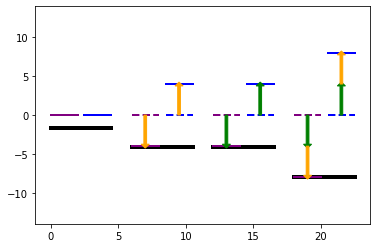

In [5]:
plot_state_cycle(0,0,-4,4,-4,4)
#plt.savefig("fig2_scenario-2.pdf")
plt.show()

# Panel 2C: Excited structures with different starting stabilities

Ab-ab: -3.907666740264634
AB-ab: -3.996271967346157
Epistasis: -0.08860522708152319


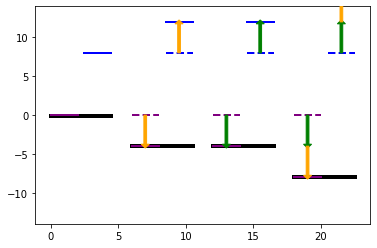

In [6]:
plot_state_cycle(0,8,-4,4,-4,4)
#plt.savefig("fig2_scenario-1.pdf")
plt.show()

# Panel 2D: Mutations with identical effects on states

Ab-ab: -3.999999999999999
AB-ab: -4.0
Epistasis: -8.881784197001252e-16


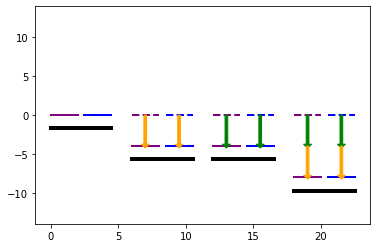

In [7]:
plot_state_cycle(0,0,-4,-4,-4,-4)
#plt.savefig("fig2_scenario-1.pdf")
plt.show()